In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [6]:
aggr = aggregate_by_label(df, 'Language', 2)

In [22]:
tfidf = TfidfVectorizer(
    #stop_words=get_stop_words('de'),
    max_features=100)

X = tfidf.fit_transform(aggr.text)

In [23]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X.todense())
#Xr = PCA(n_components=2).fit_transform(X.todense())

In [24]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [25]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0          English
 1           French
 2           German
 3         Japanese
 5          Spanish
 6           Korean
 9          Turkish
 10        Mandarin
 14       Norwegian
 15           Dutch
 16          Danish
 17         Russian
 18         Italian
 19         Swedish
 21       Icelandic
 22       Cantonese
 25            Thai
 27           Hindi
 29      Portuguese
 39         Chinese
 43          Polish
 49           Greek
 52    Swiss German
 60          Arabic
 64        Romanian
 65      Vietnamese
 72          Hebrew
 78         Finnish
 Name: label, dtype: object,
 28)

In [26]:
from sklearn.mixture import GaussianMixture

clu = GaussianMixture(n_components=n_single_labels)
Xpca = UMAP(n_components=3).fit_transform(X.todense())

cluster = clu.fit_predict(Xpca)
probs = clu.predict_proba(Xpca)

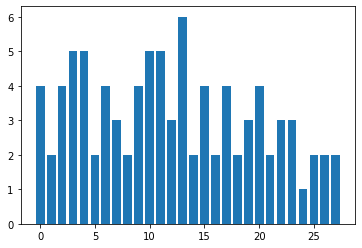

In [27]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [32]:
probs.std(axis=1)

array([0.18556807, 0.18361516, 0.18557687, 0.18557687, 0.18557687,
       0.18557687, 0.18557687, 0.18557235, 0.1855768 , 0.18557687,
       0.18534897, 0.18557687, 0.18557687, 0.18557681, 0.18557687,
       0.18557687, 0.18557687, 0.18557682, 0.18557687, 0.18557687,
       0.18557687, 0.18557687, 0.18557687, 0.18557586, 0.18557687,
       0.18557636, 0.18557687, 0.1855423 , 0.18557687, 0.18557687,
       0.18557687, 0.18557687, 0.18557687, 0.18478073, 0.18557687,
       0.18557687, 0.18557687, 0.18532095, 0.18557687, 0.18557687,
       0.18557675, 0.18557687, 0.18557687, 0.18557687, 0.18557687,
       0.18557687, 0.18557687, 0.18557687, 0.18557687, 0.18550636,
       0.18557687, 0.18557685, 0.18557687, 0.18556533, 0.18557687,
       0.18557687, 0.18557687, 0.18557687, 0.1855644 , 0.18557687,
       0.18557675, 0.18557687, 0.18557687, 0.18557687, 0.18557687,
       0.18557687, 0.18021028, 0.18557687, 0.18557687, 0.18557687,
       0.18557687, 0.18557687, 0.18557687, 0.18557687, 0.18557

In [29]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

Need more colors than current cmap holds


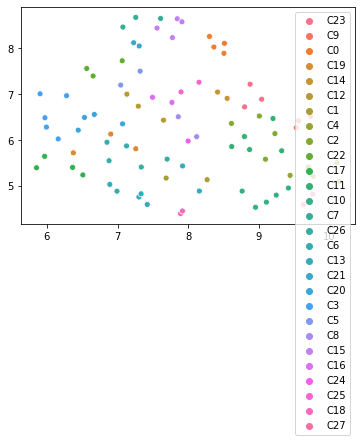

In [40]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in cluster])

In [33]:
dfs = get_cluster_dfs(aggr, cluster)

In [44]:
for cluster_df in dfs:
    print(cluster_df.label)
    print(f'Total number of instances in cluster => {cluster_df.n_texts.sum()}')
    print('#'*60)

2                German
11      German, English
15                Dutch
80    Norwegian, German
Name: label, dtype: object
Total number of instances in cluster => 243
############################################################
6              Korean
38    Korean, English
Name: label, dtype: object
Total number of instances in cluster => 57
############################################################
8              French, English
40    English, French, Italian
42            Swedish, English
50              English, Latin
Name: label, dtype: object
Total number of instances in cluster => 61
############################################################
25                            Thai
39                         Chinese
60                          Arabic
65                      Vietnamese
82    Mandarin, Cantonese, English
Name: label, dtype: object
Total number of instances in cluster => 28
############################################################
7                  English, French
3